In [22]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import optuna
from xgboost_autotune import fit_parameters
from scipy import stats

In [23]:
data_path = './data/'
df = pd.read_csv(data_path + 'trainData.csv')

#To DROP NAXUI:
to_drop = ['NameV', 'EmbarkedQ', 'SibSp']
df.drop(to_drop, axis=1, inplace=True)
#df = df[[*to_drop] + ['Survived']]


X = df.drop('Survived', axis=1)
y = df.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

,Pclass,Age,Parch,Fare,SexQ
298,1,28.00,0,34.177267,0
884,3,25.00,0,19.530276,0
247,2,24.00,2,26.741486,1
478,3,22.00,0,20.176725,0
305,1,0.92,2,50.209156,0


In [24]:
model = XGBClassifier(objective = 'binary:logistic')
params = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

In [28]:
#RANDOMIZED SEARCH!!!!
numFolds = 5
kfold_5 = KFold(shuffle = True, n_splits = numFolds)

rs_clf = RandomizedSearchCV(model, 
                         param_distributions = params,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)
rs_clf.fit(X_train, y_train)

best_model = rs_clf.best_estimator_
best_params_rand = rs_clf.best_params_
best_params_rand

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[14:48:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.7400494548543555,
 'learning_rate': 0.03929111922200751,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 870,
 'subsample': 0.7003260886604549}

In [84]:
#optune
def objective(trial):
    op_params = {
        'eval_metric' : ['logloss'],
        'max_depth' : trial.suggest_int('max_depth', 1, 10),
        'learning_rate' : trial.suggest_float('learning_rate', 0.001, 0.3),
        'subsample' : trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 100.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100)

    }

    X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    model = XGBClassifier(**op_params)
    model.fit(X_train_l, y_train_l)

    preds = model.predict(X_test_l)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test_l, pred_labels)
    return accuracy
  
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

#BEST PARAMS HERE
trial = study.best_trial
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

m[I 2021-03-06 13:03:54,329] Trial 56 finished with value: 0.8263473053892215 and parameters: {'max_depth': 7, 'learning_rate': 0.22765942176352524, 'subsample': 0.5482358557012625, 'colsample_bytree': 0.8271651118791763, 'colsample_bylevel': 0.7734594191576247, 'min_child_weight': 0.675714261388956, 'gamma': 0.18263286329288653, 'reg_lambda': 17.778627396864028, 'n_estimators': 70}. Best is trial 42 with value: 0.8263473053892215.
[I 2021-03-06 13:03:54,422] Trial 57 finished with value: 0.7964071856287425 and parameters: {'max_depth': 9, 'learning_rate': 0.22906560820351893, 'subsample': 0.5524033254382076, 'colsample_bytree': 0.8174522452643813, 'colsample_bylevel': 0.5805590089760635, 'min_child_weight': 1.0601408696613488, 'gamma': 0.7616110643298839, 'reg_lambda': 16.647578275425516, 'n_estimators': 69}. Best is trial 42 with value: 0.8263473053892215.
[I 2021-03-06 13:03:54,540] Trial 58 finished with value: 0.7664670658682635 and parameters: {'max_depth': 7, 'learning_rate': 0.

[14:48:29] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8340807174887892


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

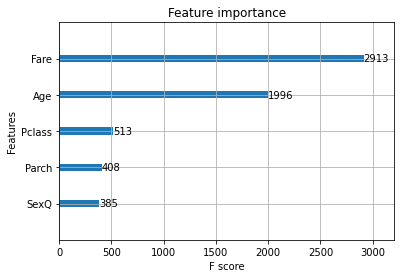

In [29]:
#BEST MODEL ACCURACY

#best_model = XGBClassifier(**grid_search_res['params'])
#best_model = XGBClassifier(**trial.params)
best_model = XGBClassifier(**best_params_rand, objective = 'binary:logistic')

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print( accuracy_score(y_pred, y_test) )
plot_importance( best_model )

In [30]:
# CREATING NEW FEATURE
xgboost_new_feature = best_model.predict(X)

dfNew = pd.read_csv(data_path + 'trainDataNF.csv')
dfNew['xgBoost'] = xgboost_new_feature

pd.DataFrame(dfNew).to_csv(data_path + "trainDataNF.csv")

In [14]:
#GETTTING ANSWER!!!
best_model.fit(X, y, objective = 'binary:logistic')

X_test_real = pd.read_csv(data_path + 'testData.csv')
X_test_real.drop(to_drop, axis=1, inplace=True)

y_pred_real = best_model.predict(X_test_real)

dfRealTest = pd.read_csv(data_path + "test.csv")
dfRealTest["Survived"] = y_pred_real
dfRealTest = dfRealTest[["PassengerId", "Survived"]]


dfRealTest = dfRealTest.set_index("PassengerId")
pd.DataFrame(dfRealTest).to_csv(data_path + "answer.csv")

[14:29:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
